In [1]:
import sys
import numpy as np
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import BatchNormalization
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.datasets import mnist
from random import randint
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
class Discriminator(object):
    def __init__(self, width = 28, height= 28, channels = 1, latent_size=100):
        self.CAPACITY = width*height*channels
        self.SHAPE = (width,height,channels)
        self.OPTIMIZER = Adam(lr=0.0002, decay=8e-9)

        self.Discriminator = self.model()
        self.Discriminator.compile(loss='binary_crossentropy', optimizer=self.OPTIMIZER, metrics=['accuracy'] )
        self.summary()

    def model(self):
        model = Sequential()
        # 28,28,1 
        model.add(Flatten(input_shape=self.SHAPE))
        # 28*28*1 = 784
        model.add(Dense(self.CAPACITY, input_shape=self.SHAPE))
        # (28,28,1) -> (784)
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(int(self.CAPACITY/2)))
        # (784) -> (392)
        model.add(LeakyReLU(alpha=0.2))
        # (392) -> (1) : Sigmoid 0~1
        model.add(Dense(1, activation='sigmoid'))
        return model

    def summary(self):
        return self.Discriminator.summary()


In [3]:
class Generator(object):
    def __init__(self, width = 28, height= 28, channels = 1, latent_size=100):
        self.W = width
        self.H = height
        self.C = channels
        self.OPTIMIZER = Adam(lr=0.0002, decay=8e-9)

        self.LATENT_SPACE_SIZE = latent_size
        self.latent_space = np.random.normal(0,1,(self.LATENT_SPACE_SIZE,))

        self.Generator = self.model()
        self.Generator.compile(loss='binary_crossentropy', optimizer=self.OPTIMIZER)
        self.summary()

    def model(self, block_starting_size=128,num_blocks=4):
        model = Sequential()
        
        block_size = block_starting_size 
        model.add(Dense(block_size, input_shape=(self.LATENT_SPACE_SIZE,)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        for i in range(num_blocks-1):
            block_size = block_size * 2
            model.add(Dense(block_size))
            model.add(LeakyReLU(alpha=0.2))
            model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(self.W * self.H * self.C, activation='tanh'))
        model.add(Reshape((self.W, self.H, self.C)))
        
        return model

    def summary(self):
        return self.Generator.summary()


In [4]:
  class GAN(object): # generator 와 discremenator를 합해주는 역할
    def __init__(self,discriminator,generator): # generator에서 나와 discremenator와 비교 발생되는 오차만큼 다시 회귀
        self.OPTIMIZER = Adam(lr=0.0002, decay=8e-9)
        self.Generator = generator
        self.Discriminator = discriminator
        self.Discriminator.trainable = False  # False 로 준 이유 : 업데이트 해주는것은 generator이기 떄문 (discriminator X) 즉, ㅇdiscriminator 를 freeze시켜줌
        
        self.gan_model = self.model()
        self.gan_model.compile(loss='binary_crossentropy', optimizer=self.OPTIMIZER)
        self.summary()

    def model(self):
        model = Sequential()
        model.add(self.Generator)
        model.add(self.Discriminator)
        return model

    def summary(self):
        return self.gan_model.summary()



In [5]:
class Trainer:
    def __init__(self, width = 28, height= 28, channels = 1, latent_size=100, epochs =50000, batch=32, checkpoint=50,model_type=-1):
        self.W = width
        self.H = height
        self.C = channels
        self.EPOCHS = epochs
        self.BATCH = batch
        self.CHECKPOINT = checkpoint
        self.model_type=model_type

        self.LATENT_SPACE_SIZE = latent_size

        self.generator = Generator(height=self.H, width=self.W, channels=self.C, latent_size=self.LATENT_SPACE_SIZE)
        self.discriminator = Discriminator(height=self.H, width=self.W, channels=self.C)
        self.gan = GAN(generator=self.generator.Generator, discriminator=self.discriminator.Discriminator)

        self.load_MNIST()

    def load_MNIST(self,model_type=7): # 해당하는 타입의 숫자들만 불러오겠다는 함수
        allowed_types = [-1,0,1,2,3,4,5,6,7,8,9]
        if self.model_type not in allowed_types:
            print('ERROR: Only Integer Values from -1 to 9 are allowed')

        (self.X_train, self.Y_train), (_, _) = mnist.load_data()
        if self.model_type!=-1:
            self.X_train = self.X_train[np.where(self.Y_train==int(self.model_type))[0]]
            #                                        라벨값에 대한 인덱스를 반환 / 그로써 인덱스에 대한 값들을 모아서 리스트에 저장이 가능
        
        # Rescale -1 to 1
        # Find Normalize Function from CV Class  
        self.X_train = ( np.float32(self.X_train) - 127.5) / 127.5
        self.X_train = np.expand_dims(self.X_train, axis=3)# 3D tensor
        return

    def train(self):
        for e in range(self.EPOCHS):
            # Train Discriminator
            # Make the training batch for this model be half real, half noise
            # Grab Real Images for this training batch
            count_real_images = int(self.BATCH/2)
            starting_index = randint(0, (len(self.X_train)-count_real_images))
            real_images_raw = self.X_train[ starting_index : (starting_index + count_real_images) ]
            x_real_images = real_images_raw.reshape( count_real_images, self.W, self.H, self.C )
            y_real_labels = np.ones([count_real_images,1]) #정답값(1)의 라벨을 준비

            # Grab Generated Images for this training batch
            latent_space_samples = self.sample_latent_space(count_real_images)
            x_generated_images = self.generator.Generator.predict(latent_space_samples)
            y_generated_labels = np.zeros([self.BATCH-count_real_images,1])

            # Combine to train on the discriminator
            x_batch = np.concatenate( [x_real_images, x_generated_images] )
            y_batch = np.concatenate( [y_real_labels, y_generated_labels] )

            # Now, train the discriminator with this batch
            discriminator_loss = self.discriminator.Discriminator.train_on_batch(x_batch,y_batch)[0]
        # train on batch = 하나의 데이터 배치에 대해서 경사업데이트 1회 실시
            # Generate Noise
            x_latent_space_samples = self.sample_latent_space(self.BATCH)
            y_generated_labels = np.ones([self.BATCH,1])
            generator_loss = self.gan.gan_model.train_on_batch(x_latent_space_samples,y_generated_labels)
            
            if e % self.CHECKPOINT == 0 :
              print ('Epoch: '+str(int(e))+', [Discriminator :: Loss: '+str(discriminator_loss)+'], [ Generator :: Loss: '+str(generator_loss)+']')
              self.plot_checkpoint(e)
                        
        return

    def sample_latent_space(self, instances):
        return np.random.normal(0, 1, (instances,self.LATENT_SPACE_SIZE))

    def plot_checkpoint(self,e):
        noise = self.sample_latent_space(16)
        images = self.generator.Generator.predict(noise)
        
        plt.figure(figsize=(4,4))
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.H,self.W])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        plt.show()
#         plt.close('all')
        return

In [6]:
# Command Line Argument Method
HEIGHT  = 28
WIDTH   = 28
CHANNEL = 1
LATENT_SPACE_SIZE = 100
EPOCHS = 5000
BATCH = 32
CHECKPOINT = 100
MODEL_TYPE = 7

In [7]:
trainer = Trainer(height=HEIGHT,\
                 width=WIDTH,\
                 channels=CHANNEL,\
                 latent_size=LATENT_SPACE_SIZE,\
                 epochs =EPOCHS,\
                 batch=BATCH,\
                 checkpoint=CHECKPOINT,
                 model_type=MODEL_TYPE)



Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               12928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_______________________________________

C:\Users\hogeu\anaconda3\envs\tensorflow1\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 0, [Discriminator :: Loss: 0.655113], [ Generator :: Loss: 0.6429188]


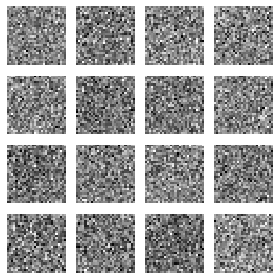

C:\Users\hogeu\anaconda3\envs\tensorflow1\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 100, [Discriminator :: Loss: 0.010444696], [ Generator :: Loss: 5.13542]


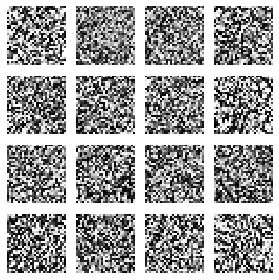

Epoch: 200, [Discriminator :: Loss: 0.022804521], [ Generator :: Loss: 5.757868]


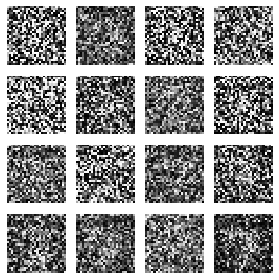

Epoch: 300, [Discriminator :: Loss: 0.06729463], [ Generator :: Loss: 6.6624928]


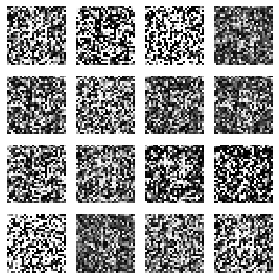

Epoch: 400, [Discriminator :: Loss: 0.017192565], [ Generator :: Loss: 6.1689267]


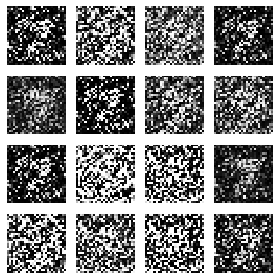

Epoch: 500, [Discriminator :: Loss: 0.049969118], [ Generator :: Loss: 9.309349]


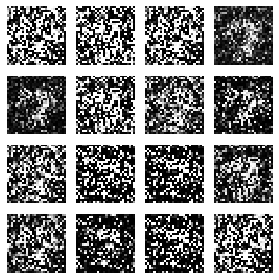

Epoch: 600, [Discriminator :: Loss: 0.011915642], [ Generator :: Loss: 9.047025]


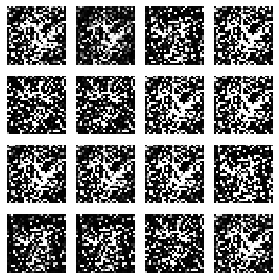

Epoch: 700, [Discriminator :: Loss: 0.020103928], [ Generator :: Loss: 9.931618]


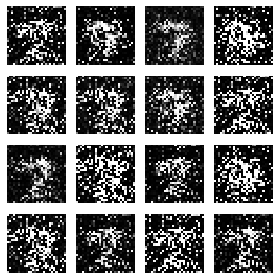

Epoch: 800, [Discriminator :: Loss: 0.20993003], [ Generator :: Loss: 7.5972657]


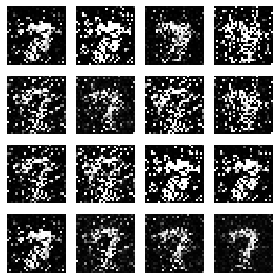

Epoch: 900, [Discriminator :: Loss: 0.061492063], [ Generator :: Loss: 5.2034807]


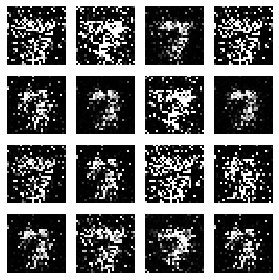

Epoch: 1000, [Discriminator :: Loss: 0.110731915], [ Generator :: Loss: 4.1653547]


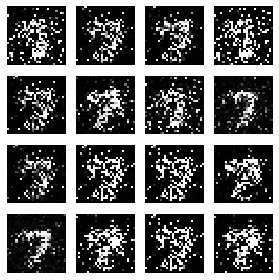

Epoch: 1100, [Discriminator :: Loss: 0.028700892], [ Generator :: Loss: 7.281604]


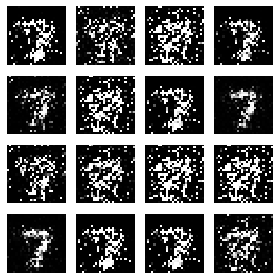

Epoch: 1200, [Discriminator :: Loss: 0.16088885], [ Generator :: Loss: 5.7978506]


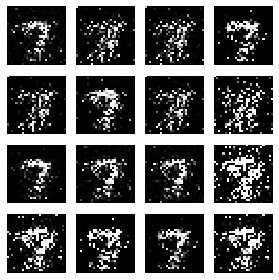

Epoch: 1300, [Discriminator :: Loss: 0.057987824], [ Generator :: Loss: 4.874815]


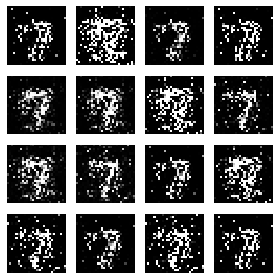

Epoch: 1400, [Discriminator :: Loss: 0.6508378], [ Generator :: Loss: 2.9425075]


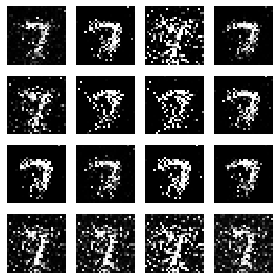

Epoch: 1500, [Discriminator :: Loss: 0.09685957], [ Generator :: Loss: 3.7748508]


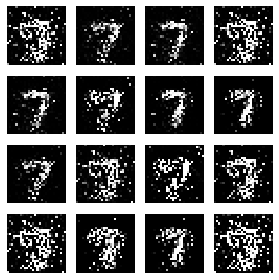

Epoch: 1600, [Discriminator :: Loss: 0.04356005], [ Generator :: Loss: 6.4753957]


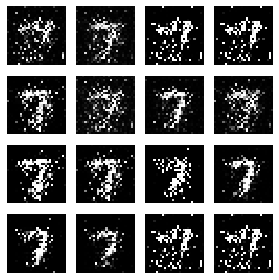

Epoch: 1700, [Discriminator :: Loss: 0.16782404], [ Generator :: Loss: 7.30462]


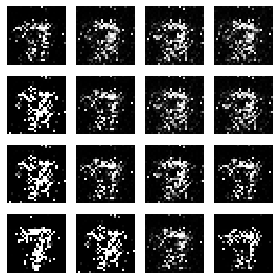

Epoch: 1800, [Discriminator :: Loss: 0.23198521], [ Generator :: Loss: 2.9756126]


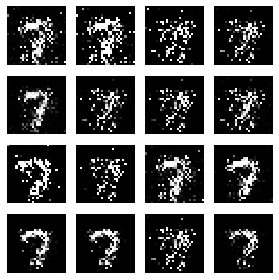

Epoch: 1900, [Discriminator :: Loss: 0.18345074], [ Generator :: Loss: 11.340649]


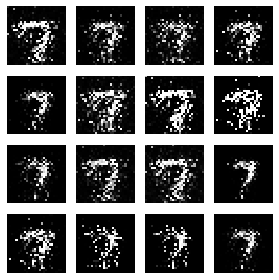

Epoch: 2000, [Discriminator :: Loss: 0.027395422], [ Generator :: Loss: 2.9241905]


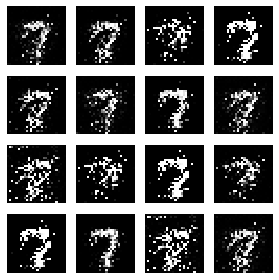

Epoch: 2100, [Discriminator :: Loss: 0.12327618], [ Generator :: Loss: 4.7823334]


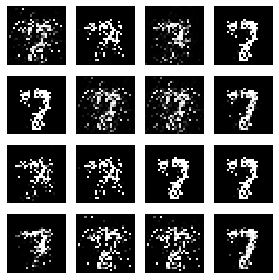

Epoch: 2200, [Discriminator :: Loss: 0.12684412], [ Generator :: Loss: 5.056237]


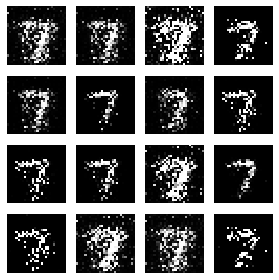

Epoch: 2300, [Discriminator :: Loss: 0.11768977], [ Generator :: Loss: 8.053457]


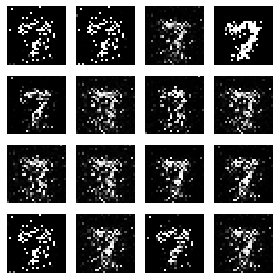

Epoch: 2400, [Discriminator :: Loss: 0.6540837], [ Generator :: Loss: 8.103897]


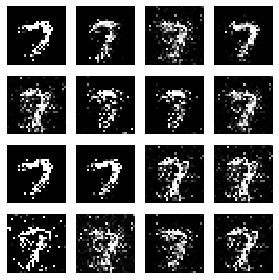

Epoch: 2500, [Discriminator :: Loss: 0.23206389], [ Generator :: Loss: 3.0052686]


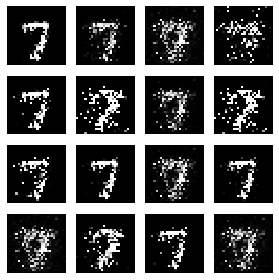

Epoch: 2600, [Discriminator :: Loss: 0.11100383], [ Generator :: Loss: 3.9936628]


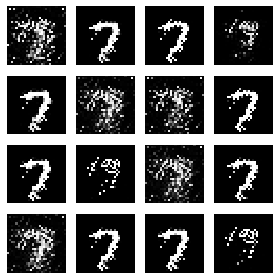

Epoch: 2700, [Discriminator :: Loss: 0.12128797], [ Generator :: Loss: 1.3386667]


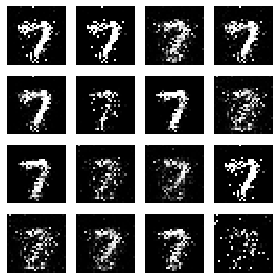

Epoch: 2800, [Discriminator :: Loss: 0.14521454], [ Generator :: Loss: 1.8144971]


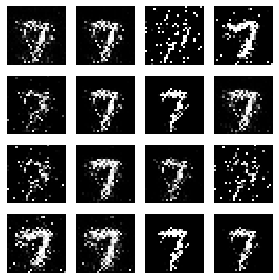

Epoch: 2900, [Discriminator :: Loss: 0.052468657], [ Generator :: Loss: 3.5458827]


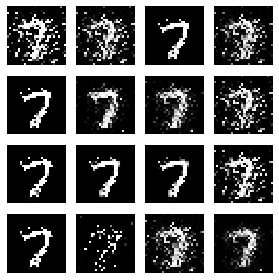

Epoch: 3000, [Discriminator :: Loss: 0.057107985], [ Generator :: Loss: 4.780945]


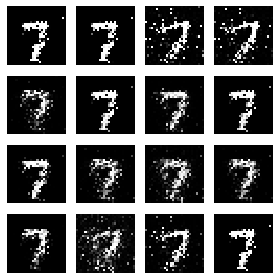

Epoch: 3100, [Discriminator :: Loss: 0.11182794], [ Generator :: Loss: 5.3766828]


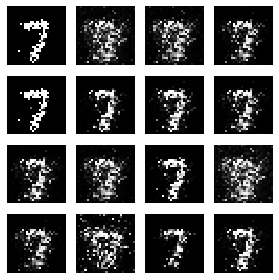

Epoch: 3200, [Discriminator :: Loss: 0.4430092], [ Generator :: Loss: 5.6693344]


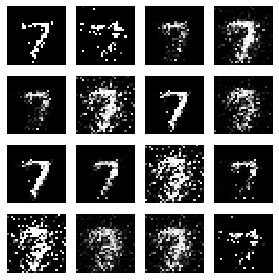

Epoch: 3300, [Discriminator :: Loss: 0.48936152], [ Generator :: Loss: 5.018785]


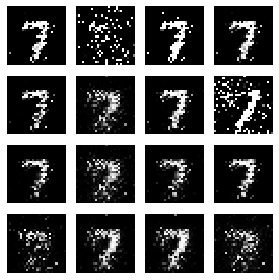

Epoch: 3400, [Discriminator :: Loss: 0.15281767], [ Generator :: Loss: 5.860628]


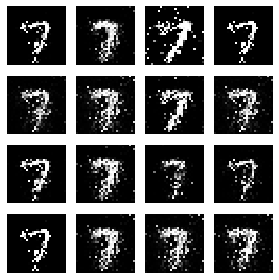

Epoch: 3500, [Discriminator :: Loss: 0.23424312], [ Generator :: Loss: 4.130134]


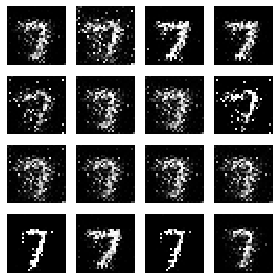

Epoch: 3600, [Discriminator :: Loss: 0.39875597], [ Generator :: Loss: 4.630028]


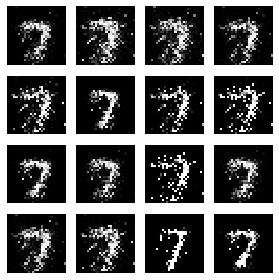

Epoch: 3700, [Discriminator :: Loss: 0.3422638], [ Generator :: Loss: 3.5030088]


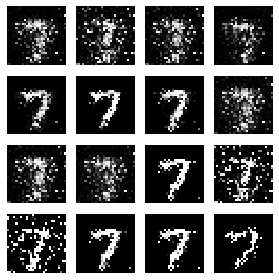

Epoch: 3800, [Discriminator :: Loss: 0.37260824], [ Generator :: Loss: 2.61872]


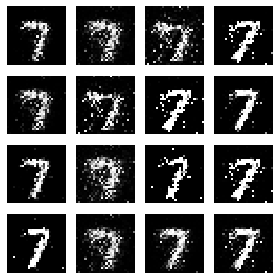

Epoch: 3900, [Discriminator :: Loss: 0.41935122], [ Generator :: Loss: 4.511405]


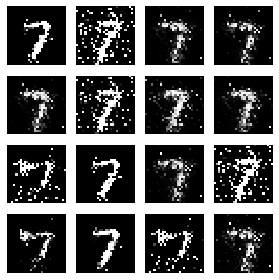

Epoch: 4000, [Discriminator :: Loss: 0.25603923], [ Generator :: Loss: 3.6843195]


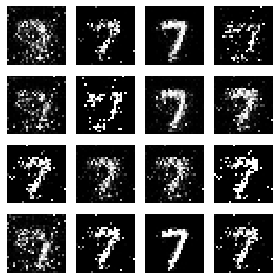

Epoch: 4100, [Discriminator :: Loss: 0.33381763], [ Generator :: Loss: 2.97913]


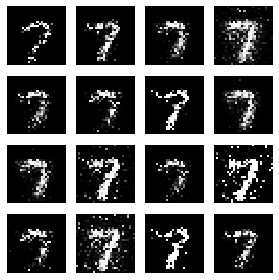

Epoch: 4200, [Discriminator :: Loss: 0.29088187], [ Generator :: Loss: 3.3394308]


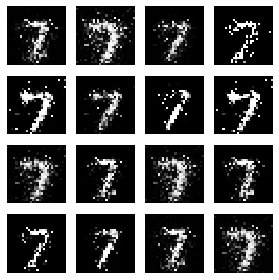

Epoch: 4300, [Discriminator :: Loss: 0.71795845], [ Generator :: Loss: 4.858342]


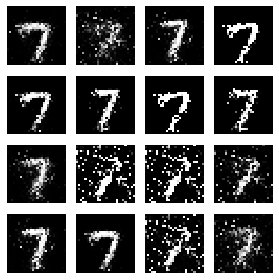

Epoch: 4400, [Discriminator :: Loss: 0.3524236], [ Generator :: Loss: 1.4265225]


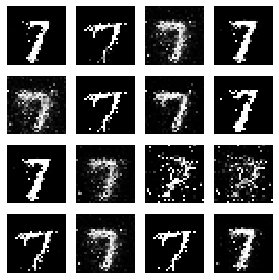

Epoch: 4500, [Discriminator :: Loss: 0.25520438], [ Generator :: Loss: 3.7996392]


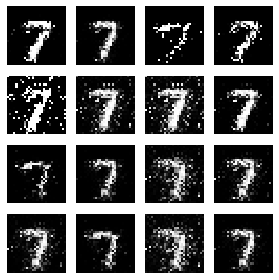

Epoch: 4600, [Discriminator :: Loss: 0.39751714], [ Generator :: Loss: 2.8826127]


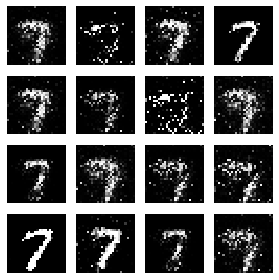

Epoch: 4700, [Discriminator :: Loss: 0.10569312], [ Generator :: Loss: 3.0425205]


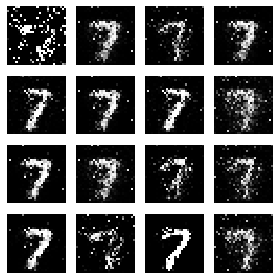

Epoch: 4800, [Discriminator :: Loss: 0.7098119], [ Generator :: Loss: 4.3795824]


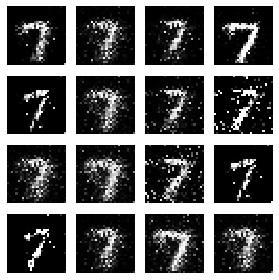

Epoch: 4900, [Discriminator :: Loss: 0.49403238], [ Generator :: Loss: 1.8299288]


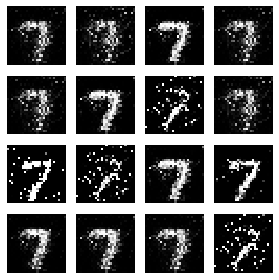

In [8]:
trainer.train()

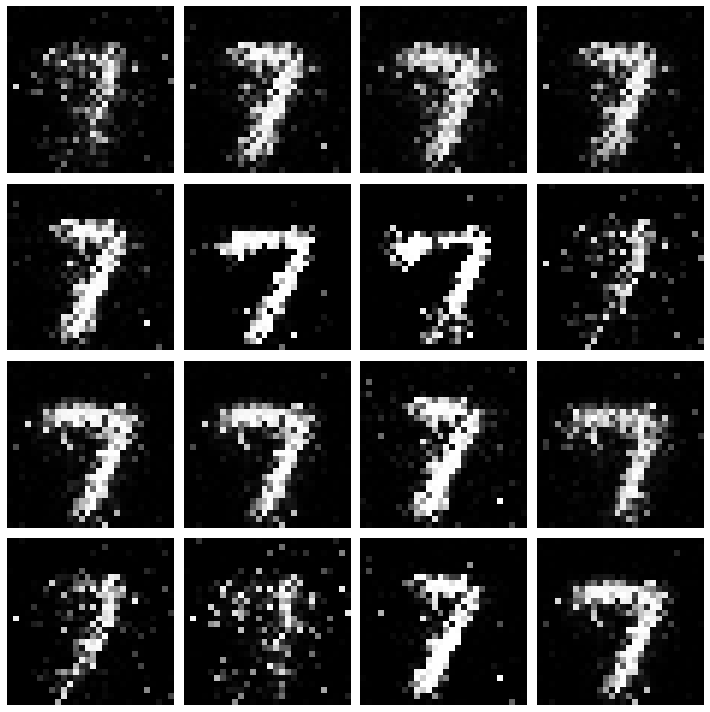

In [9]:
noise = trainer.sample_latent_space(16)
images = trainer.generator.Generator.predict(noise)

plt.figure(figsize=(10,10))
for i in range(images.shape[0]):
    plt.subplot(4, 4, i+1)
    image = images[i, :, :, :]
    image = np.reshape(image, [28,28])
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()
        